# <p style="text-align: center;">🏏 IPL Analysis using PySpark 🏏</p>


In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Checkversion").getOrCreate()
print(spark.version)

3.5.4


####🏏 IPL Dataset Analysis Questions
* 1️⃣ Total Matches Played per Season
* 2️⃣ Total Matches Played in Each City
* 3️⃣ Most Successful Teams (by Wins)
* 4️⃣ Toss Decisions Breakdown (Bat/Field)
* 5️⃣ Most Toss Wins by a Team
* 6️⃣ Matches Won by Toss-Winning Teams
* 7️⃣ Teams Winning After Batting First vs Chasing
* 8️⃣ Biggest Win by Runs in IPL History
* 9️⃣ Highest Successful Run Chases
* 🔟 Most Player of the Match Awards (Top 10)
* 1️⃣1️⃣ Most Matches Played in a Venue
* 1️⃣2️⃣ Number of Matches with Super Over
* 1️⃣3️⃣ Top Umpires Who Officiated the Most Matches
* 1️⃣4️⃣ Players Who Scored Most Runs in IPL (Top 10)
* 1️⃣5️⃣ Bowlers with Most Wickets in IPL (Top 10)
* 1️⃣6️⃣ Batsmen with the Highest Strike Rate (Min 500 Balls)
* 1️⃣7️⃣ Batsmen with Most Sixes in IPL
* 1️⃣8️⃣ Bowlers with Best Economy Rates (Min 100 Overs)
* 1️⃣9️⃣ Total Extra Runs Conceded by Each Team
* 2️⃣0️⃣ Most Common Modes of Dismissal in IPL



#### DownLoad  IPL datasets in from Kgglehub  import kagglehub library

* import kagglehub

##### Download latest version
* path = kagglehub.dataset_download("patrickb1912/ipl-complete-dataset-20082020")

* print("Path to dataset files:", path)

In [3]:
import os

dataset_path = r"C:\Users\Monoj Das\.cache\kagglehub\datasets\patrickb1912\ipl-complete-dataset-20082020\versions\3"

# List files
files = os.listdir(dataset_path)
print("Files in dataset:", files)


Files in dataset: ['deliveries.csv', 'matches.csv']


#### 📁Taking data from local datapath

In [4]:
from pyspark.sql import SparkSession
# Create a spark session 
spark = SparkSession.builder.appName("IPL analysis").getOrCreate()
# Define the path
dataset_path = r"C:\Users\Monoj Das\.cache\kagglehub\datasets\patrickb1912\ipl-complete-dataset-20082020\versions\3" 


#### importing all library from our analysis 

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


####  🛢️Now read the dataset from dataset_path as name of df_match  and d_deliveries  in spark

In [6]:
df_match = spark.read.csv(f"{dataset_path}/matches.csv", header=True, inferSchema=True)
df_deliveries = spark.read.csv(f"{dataset_path}/deliveries.csv", header= True, inferSchema = True)

# see the data  for matches data
print("Match data: ")
df_match.show(2)

# see the data  for deliveries data
print("Deliveries data: ")
df_deliveries.show(2)




Match data: 
+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+------+-------------+-----------+------------+----------+------+---------+-----------+
|    id| season|      city|      date|match_type|player_of_match|               venue|               team1|               team2|         toss_winner|toss_decision|              winner|result|result_margin|target_runs|target_overs|super_over|method|  umpire1|    umpire2|
+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+------+-------------+-----------+------------+----------+------+---------+-----------+
|335982|2007/08| Bangalore|18-04-2008|    League|    BB McCullum|M Chinnaswamy Sta...|Royal Challengers...|Kolkata Knight Ri...|Royal Challengers...|        field|Kolkata Kni

#### ✅ Check If Any Column Has Null Values

In [7]:
from pyspark.sql.functions import  col, when, count
df_match.select([count(when(col(c).isNull(),c)).alias(c) for c in df_match.columns]).show()


+---+------+----+----+----------+---------------+-----+-----+-----+-----------+-------------+------+------+-------------+-----------+------------+----------+------+-------+-------+
| id|season|city|date|match_type|player_of_match|venue|team1|team2|toss_winner|toss_decision|winner|result|result_margin|target_runs|target_overs|super_over|method|umpire1|umpire2|
+---+------+----+----+----------+---------------+-----+-----+-----+-----------+-------------+------+------+-------------+-----------+------------+----------+------+-------+-------+
|  0|     0|   0|   0|         0|              0|    0|    0|    0|          0|            0|     0|     0|            0|          0|           0|         0|     0|      0|      0|
+---+------+----+----+----------+---------------+-----+-----+-----+-----------+-------------+------+------+-------------+-----------+------------+----------+------+-------+-------+



#### ✅ Count Null Values in Each Column

In [8]:
from pyspark.sql.functions import col, sum, when
null_counts = df_match.select([
    sum(when(col(c).isNull(),1).otherwise(0)).alias(c) for c in df_match.columns
]).show()

+---+------+----+----+----------+---------------+-----+-----+-----+-----------+-------------+------+------+-------------+-----------+------------+----------+------+-------+-------+
| id|season|city|date|match_type|player_of_match|venue|team1|team2|toss_winner|toss_decision|winner|result|result_margin|target_runs|target_overs|super_over|method|umpire1|umpire2|
+---+------+----+----+----------+---------------+-----+-----+-----+-----------+-------------+------+------+-------------+-----------+------------+----------+------+-------+-------+
|  0|     0|   0|   0|         0|              0|    0|    0|    0|          0|            0|     0|     0|            0|          0|           0|         0|     0|      0|      0|
+---+------+----+----+----------+---------------+-----+-----+-----+-----------+-------------+------+------+-------------+-----------+------------+----------+------+-------+-------+



In [9]:
from pyspark.sql.functions import when

# Standardize team names
df_match = df_match.withColumn(
    "winner",
    when(col("winner").isin(["Pune Warriors", "Rising Pune Supergiant", "Rising Pune Supergiants"]), "Pune Supergiants (PS)")
    .when(col("winner").isin(["Sunrisers Hyderabad", "Deccan Chargers"]), "Sunrisers Hyderabad (SRH)")
    .when(col("winner").isin(["Lucknow Super Giants"]), "Lucknow Super Giants (LSG)")
    .when(col("winner").isin(["Kochi Tuskers Kerala"]), "Kochi Tuskers Kerala (KTK")
    .when(col("winner").isin(["Gujarat Titans", "Gujarat Lions"]), "Gujarat Titans (GT)")
    .when(col("winner").isin(["Chennai Super Kings"]), "Chennai Super Kings (CSK)")
    .when(col("winner").isin(["Royal Challengers Bengaluru", "Royal Challengers Bangalore" ]), "Royal Challengers Bangalore (RCB)")
    .when(col("winner").isin(["Rajasthan Royals"]), "Rajasthan Royals (RR)")
    .when(col("winner").isin(["Kolkata Knight Riders"]), "Kolkata Knight Riders (KRR)")
    .when(col("winner").isin(["Kings XI Punjab","Punjab Kings"]), "Punjab Kings (PBKS)")
    .when(col("winner").isin(["Delhi Daredevils", "Delhi Capitals"]), "Delhi Capitals (DC)")
    .when(col("winner").isin(["Mumbai Indians"]), "Mumbai Indians (MI)")
    .otherwise(col("winner"))
)

# Verify the replacement
df_match.select("winner").distinct().show(truncate=False)


+---------------------------------+
|winner                           |
+---------------------------------+
|Lucknow Super Giants (LSG)       |
|Kolkata Knight Riders (KRR)      |
|Royal Challengers Bangalore (RCB)|
|NA                               |
|Pune Supergiants (PS)            |
|Delhi Capitals (DC)              |
|Chennai Super Kings (CSK)        |
|Gujarat Titans (GT)              |
|Sunrisers Hyderabad (SRH)        |
|Mumbai Indians (MI)              |
|Punjab Kings (PBKS)              |
|Kochi Tuskers Kerala (KTK        |
|Rajasthan Royals (RR)            |
+---------------------------------+



In [10]:
# check the all schema  in the dataframe
print("match data all schema name list: ")
df_match.printSchema()

print("deliveries data all schema name list: ")
df_deliveries.printSchema()


# we can also use column function to see all column name list
# df_match_columns = df_match.columns
# df_deliveries_columns  = ddf_deliveries.columns


match data all schema name list: 
root
 |-- id: integer (nullable = true)
 |-- season: string (nullable = true)
 |-- city: string (nullable = true)
 |-- date: string (nullable = true)
 |-- match_type: string (nullable = true)
 |-- player_of_match: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- team1: string (nullable = true)
 |-- team2: string (nullable = true)
 |-- toss_winner: string (nullable = true)
 |-- toss_decision: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- result: string (nullable = true)
 |-- result_margin: string (nullable = true)
 |-- target_runs: string (nullable = true)
 |-- target_overs: string (nullable = true)
 |-- super_over: string (nullable = true)
 |-- method: string (nullable = true)
 |-- umpire1: string (nullable = true)
 |-- umpire2: string (nullable = true)

deliveries data all schema name list: 
root
 |-- match_id: integer (nullable = true)
 |-- inning: integer (nullable = true)
 |-- batting_team: string (nullable =

In [11]:
df_deliveries.count

<bound method DataFrame.count of DataFrame[match_id: int, inning: int, batting_team: string, bowling_team: string, over: int, ball: int, batter: string, bowler: string, non_striker: string, batsman_runs: int, extra_runs: int, total_runs: int, extras_type: string, is_wicket: int, player_dismissed: string, dismissal_kind: string, fielder: string]>

In [12]:
# Total Matches
total_matches = df_match.count()
print(f"Total Matches Played: {total_matches}")

# Total Balls Bowled
total_deliveries = df_deliveries.count()
print(f"Total Balls Bowled: {total_deliveries}")


Total Matches Played: 1095
Total Balls Bowled: 260920


In [13]:
df_match.count()

1095

In [14]:
df_deliveries.count()

260920

## 1️⃣ Total Matches Played per Season

In [15]:
from pyspark.sql.functions import col, count

total_matches_per_season = df_match.groupby("season").agg(count("id").alias("Total_matchs"))
total_matches_per_season.orderBy(col("Total_matchs").desc()).show()

+-------+------------+
| season|Total_matchs|
+-------+------------+
|   2013|          76|
|   2012|          74|
|   2022|          74|
|   2023|          74|
|   2011|          73|
|   2024|          71|
|2009/10|          60|
|   2016|          60|
|   2019|          60|
|   2014|          60|
|2020/21|          60|
|   2018|          60|
|   2021|          60|
|   2017|          59|
|   2015|          59|
|2007/08|          58|
|   2009|          57|
+-------+------------+



## 2️⃣ Total Matches Played in Each City 

In [16]:
from pyspark.sql.functions import col, count

total_matches_per_season = df_match.groupby("city").agg(count("id").alias("Total_matchs"))
total_matches_per_season.orderBy(col("Total_matchs").desc()).show()

+-------------+------------+
|         city|Total_matchs|
+-------------+------------+
|       Mumbai|         173|
|      Kolkata|          93|
|        Delhi|          90|
|      Chennai|          85|
|    Hyderabad|          77|
|    Bangalore|          65|
|   Chandigarh|          61|
|       Jaipur|          57|
|           NA|          51|
|         Pune|          51|
|    Abu Dhabi|          37|
|    Ahmedabad|          36|
|    Bengaluru|          29|
|       Durban|          15|
|Visakhapatnam|          15|
|      Lucknow|          14|
|   Dharamsala|          13|
|        Dubai|          13|
|    Centurion|          12|
|      Sharjah|          10|
+-------------+------------+
only showing top 20 rows



## 3️⃣ Most Successful Teams (by Wins)

In [17]:
from pyspark.sql.functions import col, count
# count the number of wins for each team
print("most_successful_winner_teams: ")
most_successful_winner_teams = (df_match.groupby("winner").agg(count("id").alias("total_wins"))).orderBy(col("total_wins").desc()).show()


most_successful_winner_teams: 
+--------------------+----------+
|              winner|total_wins|
+--------------------+----------+
| Mumbai Indians (MI)|       144|
|Chennai Super Kin...|       138|
|Kolkata Knight Ri...|       131|
|Royal Challengers...|       123|
|Sunrisers Hyderab...|       117|
| Delhi Capitals (DC)|       115|
| Punjab Kings (PBKS)|       112|
|Rajasthan Royals ...|       112|
| Gujarat Titans (GT)|        41|
|Pune Supergiants ...|        27|
|Lucknow Super Gia...|        24|
|Kochi Tuskers Ker...|         6|
|                  NA|         5|
+--------------------+----------+



## 4️⃣ Toss Decisions Breakdown (Bat/Field)  

In [18]:
from pyspark.sql.functions import col, count
total_decisions_count = (df_match.groupby("toss_decision")
                                                         .agg(count("id").alias("total_count"))
                                                                                                ).orderBy(col("total_count").desc()).show()
#total_decisions_count.orderBy(col("total_count").desc()).show()

+-------------+-----------+
|toss_decision|total_count|
+-------------+-----------+
|        field|        704|
|          bat|        391|
+-------------+-----------+



## 5️⃣ Most Toss Wins by a Team  

In [19]:
from pyspark.sql.functions import col, count
print("most_toss_wins_team: ")
most_toss_wins_team = (df_match.groupby("toss_winner")
                      .agg(count("id").alias("total_toss_wins"))
                      .orderBy(col("total_toss_wins").desc())
                      ).show()

most_toss_wins_team: 
+--------------------+---------------+
|         toss_winner|total_toss_wins|
+--------------------+---------------+
|      Mumbai Indians|            143|
| Chennai Super Kings|            122|
|Kolkata Knight Ri...|            122|
|    Rajasthan Royals|            120|
|Royal Challengers...|            113|
| Sunrisers Hyderabad|             88|
|     Kings XI Punjab|             85|
|    Delhi Daredevils|             80|
|      Delhi Capitals|             50|
|     Deccan Chargers|             43|
|        Punjab Kings|             24|
|      Gujarat Titans|             22|
|       Pune Warriors|             20|
|Lucknow Super Giants|             19|
|       Gujarat Lions|             15|
|Royal Challengers...|              8|
|Kochi Tuskers Kerala|              8|
|Rising Pune Super...|              7|
|Rising Pune Super...|              6|
+--------------------+---------------+



## 6️⃣ Matches Won by Toss-Winning Teams

In [20]:
from pyspark.sql.functions import col, count

# Count matches where toss winner also won the match
toss_win_match_win = (df_match.filter(col("toss_winner") == col("winner"))
                      .groupBy("toss_winner")
                      .agg(count("id").alias("matches_won_after_toss_win"))
                      .orderBy(col("matches_won_after_toss_win").desc())  # Sort in descending order
                     )

# Display the result
toss_win_match_win.show()


+-----------+--------------------------+
|toss_winner|matches_won_after_toss_win|
+-----------+--------------------------+
+-----------+--------------------------+



## 7️⃣ Teams Winning After Batting First vs Chasing

In [21]:
from pyspark.sql.functions import col, count

# Count matches won by teams that batted first
bat_first_wins = (df_match.filter(col("toss_decision") == "bat")
                  .groupBy("winner")
                  .agg(count("id").alias("bat_first_wins"))
                 )

# Count matches won by teams that chased
chase_wins = (df_match.filter(col("toss_decision") == "field")
              .groupBy("winner")
              .agg(count("id").alias("chase_wins"))
             )

# Join both DataFrames on "winner" to compare side by side
team_win_comparison = (bat_first_wins.join(chase_wins, "winner", "outer")
                       .fillna(0)  # Fill missing values with 0
                       .orderBy(col("bat_first_wins").desc())  # Order by teams with most batting first wins
                      )

# Display the result
team_win_comparison.show()


+--------------------+--------------+----------+
|              winner|bat_first_wins|chase_wins|
+--------------------+--------------+----------+
|Chennai Super Kin...|            63|        75|
| Mumbai Indians (MI)|            54|        90|
|Kolkata Knight Ri...|            50|        81|
|Sunrisers Hyderab...|            44|        73|
|Rajasthan Royals ...|            43|        69|
| Delhi Capitals (DC)|            42|        73|
|Royal Challengers...|            38|        85|
| Punjab Kings (PBKS)|            28|        84|
| Gujarat Titans (GT)|            11|        30|
|Pune Supergiants ...|            11|        16|
|Lucknow Super Gia...|             6|        18|
|                  NA|             1|         4|
|Kochi Tuskers Ker...|             0|         6|
+--------------------+--------------+----------+



## 8️⃣ Biggest Win by Runs in IPL History 

In [22]:
from pyspark.sql.functions import col

# Find the match with the highest result_margin (runs)
biggest_win_by_runs = (df_match.filter(col("result") == "runs")  # Consider only matches won by runs
                       .orderBy(col("result_margin").desc())  # Sort by result_margin in descending order
                       .limit(1)  # Get the top record
                      )

# Display the result
biggest_win_by_runs.show(truncate=False)


+------+-------+-----+----------+----------+---------------+----------------+----------------+--------------+----------------+-------------+-------------------+------+-------------+-----------+------------+----------+------+-----------+-----------+
|id    |season |city |date      |match_type|player_of_match|venue           |team1           |team2         |toss_winner     |toss_decision|winner             |result|result_margin|target_runs|target_overs|super_over|method|umpire1    |umpire2    |
+------+-------+-----+----------+----------+---------------+----------------+----------------+--------------+----------------+-------------+-------------------+------+-------------+-----------+------------+----------+------+-----------+-----------+
|419114|2009/10|Delhi|17-03-2010|League    |SR Tendulkar   |Feroz Shah Kotla|Delhi Daredevils|Mumbai Indians|Delhi Daredevils|field        |Mumbai Indians (MI)|runs  |98           |219        |20          |N         |NA    |BR Doctrove|SK Tarapore|
+---

## 9️⃣ Highest Successful Run Chases  

In [23]:
import pandas as pd
from pyspark.sql.functions import col

# Filter matches where the result is based on runs (successful chases)
highest_chases = (df_match.filter((col("result") == "wickets") & (col("result_margin").isNotNull()))
                  .orderBy(col("result_margin").desc())  # Sort by highest wickets
                  .limit(5)  # Get top 5 highest successful chases
                 )

# Display the result using pandas dataframe for bertter understanding
# Convert PySpark DataFrame to Pandas for visualization
highest_chases_pd = highest_chases.toPandas()

# Display the Pandas DataFrame in a Jupyter Notebook (visual table)
from IPython.display import display
display(highest_chases_pd)

# otherwise we can use pyspark method ................
# highest_chases.show(truncate=False)


,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335984,2007/08,Delhi,19-04-2008,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Capitals (DC),wickets,9,130,20,N,NA,Aleem Dar,GA Pratapkumar
1,335988,2007/08,Hyderabad,22-04-2008,League,V Sehwag,"Rajiv Gandhi International Stadium, Uppal",Deccan Chargers,Delhi Daredevils,Deccan Chargers,bat,Delhi Capitals (DC),wickets,9,143,20,N,NA,IL Howell,AM Saheba
2,335993,2007/08,Chennai,26-04-2008,League,JDP Oram,"MA Chidambaram Stadium, Chepauk",Chennai Super Kings,Kolkata Knight Riders,Kolkata Knight Riders,bat,Chennai Super Kings (CSK),wickets,9,148,20,N,NA,BF Bowden,AV Jayaprakash
3,336016,2007/08,Chandigarh,12-05-2008,League,SE Marsh,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Royal Challengers Bangalore,Royal Challengers Bangalore,bat,Punjab Kings (PBKS),wickets,9,144,20,N,NA,BR Doctrove,I Shivram
4,336018,2007/08,Mumbai,14-05-2008,League,ST Jayasuriya,Wankhede Stadium,Mumbai Indians,Chennai Super Kings,Mumbai Indians,field,Mumbai Indians (MI),wickets,9,157,20,N,NA,BR Doctrove,AM Saheba


## 🔟 Most Player of the Match Awards (Top 10)

C:\Users\Monoj Das\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


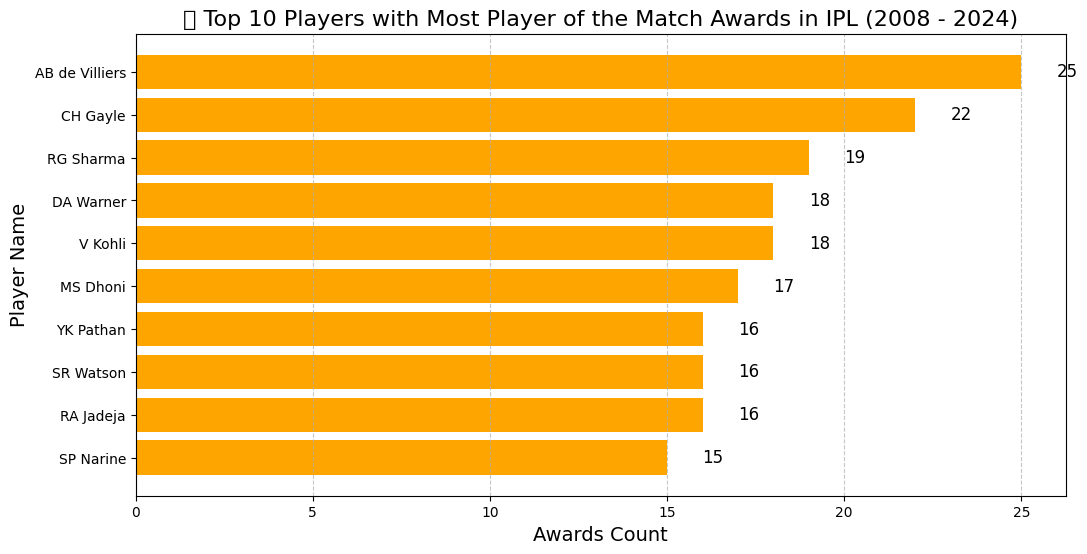

In [24]:
import pandas as pd 
import matplotlib.pyplot as plt 

from pyspark.sql.functions import col, count
# count number of times each player won "man of the match"
top_10_players = (df_match.groupby("player_of_match")
                .agg(count("id").alias("awards_count"))
                .orderBy(col("awards_count").desc())
                .limit(10))

top_players_pd = top_10_players.toPandas()
# Plot a horizontal bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(top_players_pd["player_of_match"], top_players_pd["awards_count"], color="orange")

# Add text labels on each bar
for bar, label in zip(bars, top_players_pd["awards_count"]):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(label), va='center', fontsize=12)

# Customize plot aesthetics
plt.xlabel("Awards Count", fontsize=14)
plt.ylabel("Player Name", fontsize=14)
plt.title("🏆 Top 10 Players with Most Player of the Match Awards in IPL (2008 - 2024)", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()



In [25]:
df_match.columns

['id',
 'season',
 'city',
 'date',
 'match_type',
 'player_of_match',
 'venue',
 'team1',
 'team2',
 'toss_winner',
 'toss_decision',
 'winner',
 'result',
 'result_margin',
 'target_runs',
 'target_overs',
 'super_over',
 'method',
 'umpire1',
 'umpire2']

In [26]:
df_match.select("winner").distinct().show()

+--------------------+
|              winner|
+--------------------+
|Lucknow Super Gia...|
|Kolkata Knight Ri...|
|Royal Challengers...|
|                  NA|
|Pune Supergiants ...|
| Delhi Capitals (DC)|
|Chennai Super Kin...|
| Gujarat Titans (GT)|
|Sunrisers Hyderab...|
| Mumbai Indians (MI)|
| Punjab Kings (PBKS)|
|Kochi Tuskers Ker...|
|Rajasthan Royals ...|
+--------------------+



In [27]:
df_match.filter(col("winner") == "NA").show(truncate=False)


+-------+------+---------+----------+----------+---------------+---------------------------------------------------------------------+---------------------------+-------------------+---------------------------+-------------+------+---------+-------------+-----------+------------+----------+------+---------------+-------------+
|id     |season|city     |date      |match_type|player_of_match|venue                                                                |team1                      |team2              |toss_winner                |toss_decision|winner|result   |result_margin|target_runs|target_overs|super_over|method|umpire1        |umpire2      |
+-------+------+---------+----------+----------+---------------+---------------------------------------------------------------------+---------------------------+-------------------+---------------------------+-------------+------+---------+-------------+-----------+------------+----------+------+---------------+-------------+
|501265 |2011

In [28]:
df_match.printSchema()

root
 |-- id: integer (nullable = true)
 |-- season: string (nullable = true)
 |-- city: string (nullable = true)
 |-- date: string (nullable = true)
 |-- match_type: string (nullable = true)
 |-- player_of_match: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- team1: string (nullable = true)
 |-- team2: string (nullable = true)
 |-- toss_winner: string (nullable = true)
 |-- toss_decision: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- result: string (nullable = true)
 |-- result_margin: string (nullable = true)
 |-- target_runs: string (nullable = true)
 |-- target_overs: string (nullable = true)
 |-- super_over: string (nullable = true)
 |-- method: string (nullable = true)
 |-- umpire1: string (nullable = true)
 |-- umpire2: string (nullable = true)



## 1️⃣1️⃣ Most Matches Played in a Venue

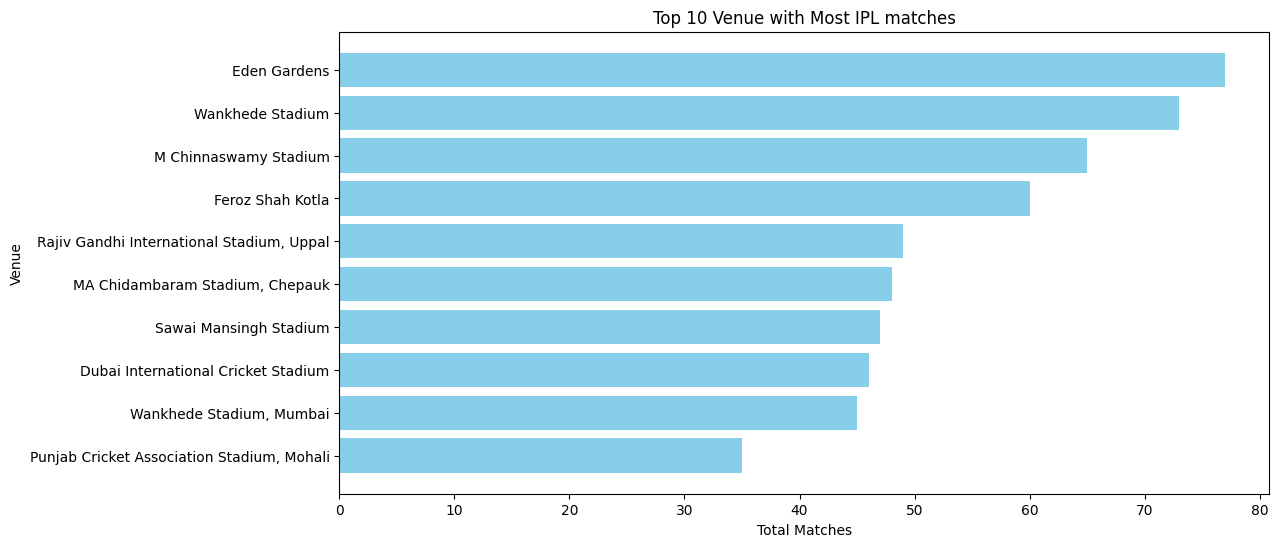

In [44]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pyspark.sql.functions import col, count
# Count number of matches at each venue 
most_matches_venue = (
    df_match.groupby("venue")
    .agg(count("id").alias("total_matches"))
    .orderBy(col("total_matches").desc()) # short in desceding order
 )               #   if we see in pyspark data  yhen-------    .show(10, truncate= False)

most_matches_venue_pd  = most_matches_venue.limit(10).toPandas()

# plot a bar chart
plt.figure(figsize=(12,6))

plt.barh(most_matches_venue_pd["venue"], most_matches_venue_pd["total_matches"], color= "skyblue")

# Labels and Title 
plt.xlabel("Total Matches")
plt.ylabel("Venue")
plt.title("Top 10 Venue with Most IPL matches")
plt.gca().invert_yaxis()
# show plot 
plt.show()







## 1️⃣2️⃣ Number of Matches with Super Over

In [49]:
from pyspark.sql.functions import col, count

# Count matches where ssuper_over is 1 (indication Super Over is ptop_players_pd)
super_over_matches = (
    df_match.filter(col("super_over") == "1")
    .agg(count("id").alias("super_over_matches"))
).show()

+------------------+
|super_over_matches|
+------------------+
|                 0|
+------------------+



## 1️⃣3️⃣ Top Umpires Who Officiated the Most Matches

In [67]:
from pyspark.sql.functions import col, count

# Count matches officiated by each umpire (umpire1 and umpire2)
umpire1_counts = df_match.groupBy("umpire1").agg(count("id").alias("match_count"))
umpire2_counts = df_match.groupBy("umpire2").agg(count("id").alias("match_count"))

# Rename columns for clarity
umpire1_counts = umpire1_counts.withColumnRenamed("umpire1", "umpire")
umpire2_counts = umpire2_counts.withColumnRenamed("umpire2", "umpire")

# Combine both umpire lists
total_umpire_counts = umpire1_counts.union(umpire2_counts)

# Group by umpire name to get total matches officiated
top_umpires = (
    total_umpire_counts.groupBy("umpire")
    .agg(count("match_count").alias("total_matches"))
    .orderBy(col("total_matches").desc())
    .limit(10)  # Get top 10 umpires
)

# Show the top 10 umpires
top_umpires.show()


+--------------------+-------------+
|              umpire|total_matches|
+--------------------+-------------+
|           BF Bowden|            2|
|        AK Chaudhary|            2|
|              S Ravi|            2|
|            SJ Davis|            2|
|           JD Cloete|            2|
|            MA Gough|            2|
|MV Saidharshan Kumar|            2|
|          SL Shastri|            2|
|       Navdeep Singh|            2|
|        Vinod Seshan|            2|
+--------------------+-------------+



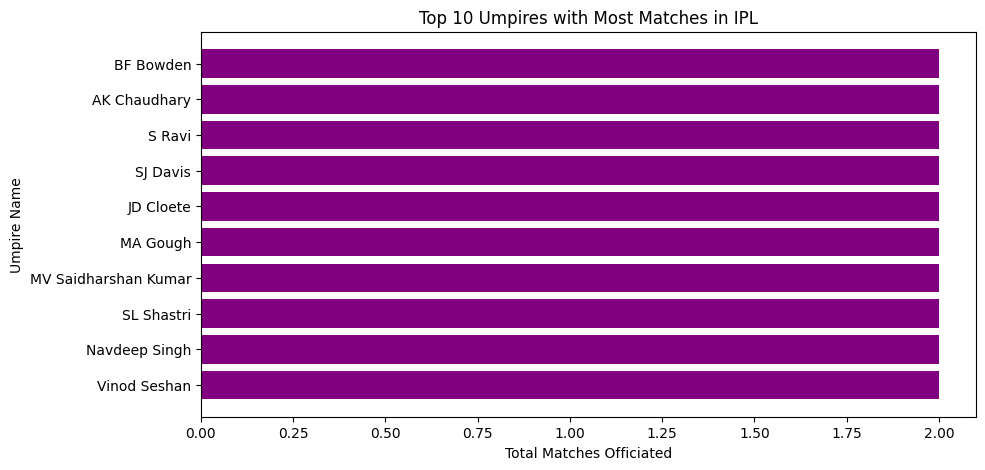

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas for visualization
top_umpires_pd = top_umpires.toPandas()

# Plot a horizontal bar chart
plt.figure(figsize=(10, 5))
plt.barh(top_umpires_pd["umpire"], top_umpires_pd["total_matches"], color="purple")

# Labels and Title
plt.xlabel("Total Matches Officiated")
plt.ylabel("Umpire Name")
plt.title("Top 10 Umpires with Most Matches in IPL")

# Invert y-axis for better readability
plt.gca().invert_yaxis()

# Show the plot
plt.show()


## 1️⃣4️⃣ Players Who Scored Most Runs in IPL (Top 10)

In [68]:
from pyspark.sql.functions import col, sum

# Aggregate total runs scored by each player
top_scorers = (
    df_deliveries.groupBy("batter")
    .agg(sum("batsman_runs").alias("total_runs"))
    .orderBy(col("total_runs").desc())  # Sort in descending order
    .limit(10)  # Get top 10 players
)

# Show top 10 run scorers
top_scorers.show()


+--------------+----------+
|        batter|total_runs|
+--------------+----------+
|       V Kohli|      8014|
|      S Dhawan|      6769|
|     RG Sharma|      6630|
|     DA Warner|      6567|
|      SK Raina|      5536|
|      MS Dhoni|      5243|
|AB de Villiers|      5181|
|      CH Gayle|      4997|
|    RV Uthappa|      4954|
|    KD Karthik|      4843|
+--------------+----------+



## 1️⃣5️⃣ Bowlers with Most Wickets in IPL (Top 10)

In [69]:
from pyspark.sql.functions import col, count

# Filter deliveries where a wicket was taken (excluding run-outs)
wickets_df = df_deliveries.filter((col("is_wicket") == 1) & (col("dismissal_kind") != "run out"))

# Count total wickets taken by each bowler
top_bowlers = (
    wickets_df.groupBy("bowler")
    .agg(count("is_wicket").alias("total_wickets"))
    .orderBy(col("total_wickets").desc())  # Sort in descending order
    .limit(10)  # Get top 10 bowlers
)

# Show top 10 wicket-takers
top_bowlers.show()


+----------+-------------+
|    bowler|total_wickets|
+----------+-------------+
| YS Chahal|          205|
| PP Chawla|          192|
|  DJ Bravo|          183|
|  R Ashwin|          181|
|   B Kumar|          181|
| SP Narine|          180|
|  A Mishra|          174|
|SL Malinga|          170|
| JJ Bumrah|          168|
| RA Jadeja|          160|
+----------+-------------+



## 1️⃣6️⃣ Batsmen with the Highest Strike Rate (Min 500 Balls)

In [70]:
from pyspark.sql.functions import col, sum, count

# Calculate total runs and total balls faced by each batsman
batsman_stats = (
    df_deliveries.groupBy("batter")
    .agg(
        sum("batsman_runs").alias("total_runs"),
        count("ball").alias("total_balls")
    )
)

# Filter players with at least 500 balls faced
batsman_stats = batsman_stats.filter(col("total_balls") >= 500)

# Calculate strike rate: (runs / balls) * 100
batsman_stats = batsman_stats.withColumn("strike_rate", (col("total_runs") / col("total_balls")) * 100)

# Sort by highest strike rate
top_strike_rates = batsman_stats.orderBy(col("strike_rate").desc()).limit(10)

# Show top 10 batsmen with the highest strike rate
top_strike_rates.show()


+---------------+----------+-----------+------------------+
|         batter|total_runs|total_balls|       strike_rate|
+---------------+----------+-----------+------------------+
|     AD Russell|      2488|       1515|164.22442244224422|
|      H Klaasen|       993|        613|161.99021207177816|
|      SP Narine|      1534|        984| 155.8943089430894|
|       N Pooran|      1769|       1143| 154.7681539807524|
| LS Livingstone|       939|        609| 154.1871921182266|
|     GJ Maxwell|      2772|       1842| 150.4885993485342|
|     RM Patidar|       799|        534|  149.625468164794|
|Abhishek Sharma|      1377|        925|148.86486486486484|
|       V Sehwag|      2728|       1833|148.82705946535734|
| AB de Villiers|      5181|       3487|148.58044164037855|
+---------------+----------+-----------+------------------+



## 1️⃣7️⃣ Batsmen with Most Sixes in IPL

In [71]:
from pyspark.sql.functions import col, count

# Filter deliveries where batsman hit a six (batsman_runs = 6)
batsman_sixes = (
    df_deliveries.filter(col("batsman_runs") == 6)
    .groupBy("batter")
    .agg(count("batsman_runs").alias("total_sixes"))
)

# Sort by most sixes in descending order
top_six_hitters = batsman_sixes.orderBy(col("total_sixes").desc()).limit(10)

# Show the top 10 batsmen with most sixes
top_six_hitters.show()


+--------------+-----------+
|        batter|total_sixes|
+--------------+-----------+
|      CH Gayle|        359|
|     RG Sharma|        281|
|       V Kohli|        273|
|AB de Villiers|        253|
|      MS Dhoni|        252|
|     DA Warner|        236|
|    KA Pollard|        224|
|    AD Russell|        209|
|     SV Samson|        206|
|      SK Raina|        204|
+--------------+-----------+



## 1️⃣8️⃣ Bowlers with Best Economy Rates (Min 100 Overs)

In [72]:
from pyspark.sql.functions import col, sum, count

# Calculate total runs conceded and total overs bowled by each bowler
bowler_stats = df_deliveries.groupBy("bowler").agg(
    sum("total_runs").alias("runs_conceded"),  # Sum of runs given
    (count("ball") / 6).alias("overs_bowled")  # Convert balls to overs
)

# Filter bowlers who have bowled at least 100 overs
qualified_bowlers = bowler_stats.filter(col("overs_bowled") >= 100)

# Calculate economy rate (Runs per Over)
economy_bowlers = qualified_bowlers.withColumn(
    "economy_rate", col("runs_conceded") / col("overs_bowled")
)

# Sort by best (lowest) economy rate
top_economy_bowlers = economy_bowlers.orderBy(col("economy_rate")).limit(10)

# Show results
top_economy_bowlers.select("bowler", "economy_rate").show()


+--------------+------------------+
|        bowler|      economy_rate|
+--------------+------------------+
|      A Kumble| 6.646998982706002|
|M Muralitharan| 6.698292220113852|
|     SP Narine|6.7612156295224315|
|      DW Steyn| 6.791411042944786|
|    DL Vettori|  6.83312101910828|
|   Rashid Khan| 6.907962771458118|
|       J Botha| 6.922425952045134|
|      R Ashwin| 6.969437914084206|
|        MM Ali| 7.012987012987012|
|    SL Malinga| 7.032952252858103|
+--------------+------------------+



## 1️⃣9️⃣ Total Extra Runs Conceded by Each Team

In [73]:
from pyspark.sql.functions import col, sum

# Group by bowling team and sum the extra runs
extra_runs_by_team = (
    df_deliveries.groupBy("bowling_team")
    .agg(sum("extra_runs").alias("total_extra_runs"))
    .orderBy(col("total_extra_runs").desc())  # Sort in descending order
)

# Show results
extra_runs_by_team.show()


+--------------------+----------------+
|        bowling_team|total_extra_runs|
+--------------------+----------------+
|      Mumbai Indians|            2295|
|Royal Challengers...|            2040|
|Kolkata Knight Ri...|            1957|
|    Rajasthan Royals|            1917|
| Chennai Super Kings|            1842|
|     Kings XI Punjab|            1571|
|    Delhi Daredevils|            1268|
| Sunrisers Hyderabad|            1254|
|      Delhi Capitals|             725|
|     Deccan Chargers|             659|
|        Punjab Kings|             480|
|Lucknow Super Giants|             386|
|       Pune Warriors|             335|
|      Gujarat Titans|             295|
|       Gujarat Lions|             188|
|Royal Challengers...|             151|
|Rising Pune Super...|             111|
|Kochi Tuskers Kerala|             110|
|Rising Pune Super...|             108|
+--------------------+----------------+



###### ✅ PySpark + Matplotlib Code for Extra Runs Plot

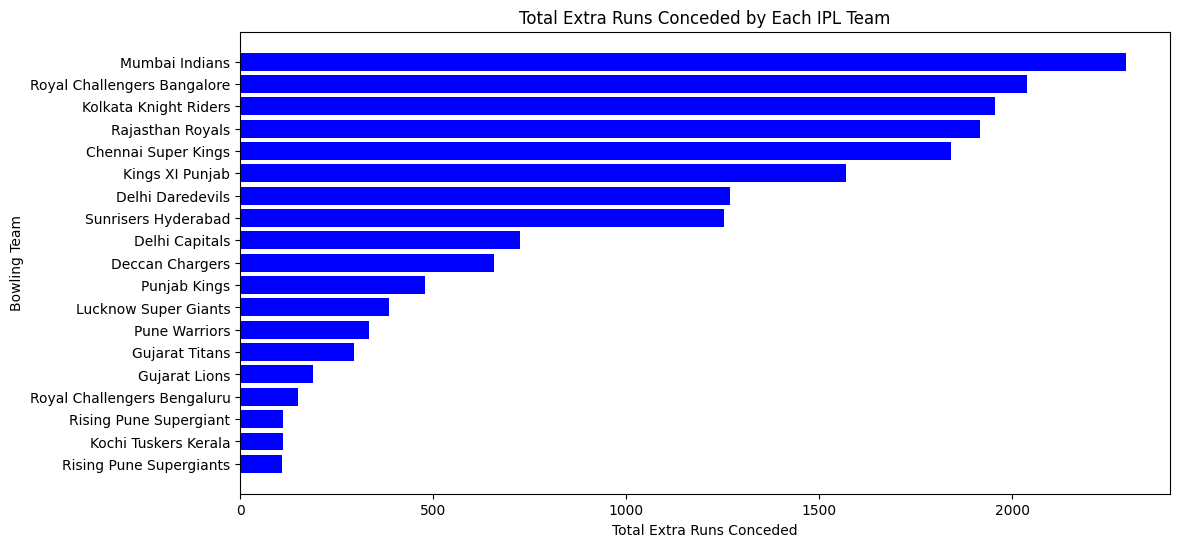

In [76]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas for visualization
extra_runs_by_team_pd = extra_runs_by_team.toPandas()

# Plot a bar chart
plt.figure(figsize=(12, 6))
plt.barh(extra_runs_by_team_pd["bowling_team"], extra_runs_by_team_pd["total_extra_runs"], color="blue")

# Labels and Title
plt.xlabel("Total Extra Runs Conceded")
plt.ylabel("Bowling Team")
plt.title("Total Extra Runs Conceded by Each IPL Team")
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Show plot
plt.show()


## 2️⃣0️⃣ Most Common Modes of Dismissal in IPL

In [77]:
from pyspark.sql.functions import col, count

# Count occurrences of each dismissal kind
dismissal_modes = (
    df_deliveries.groupBy("dismissal_kind")
    .agg(count("dismissal_kind").alias("count"))
    .orderBy(col("count").desc())
)

# Show results
dismissal_modes.show()


+--------------------+------+
|      dismissal_kind| count|
+--------------------+------+
|                  NA|247970|
|              caught|  8063|
|              bowled|  2212|
|             run out|  1114|
|                 lbw|   800|
|   caught and bowled|   367|
|             stumped|   358|
|          hit wicket|    15|
|        retired hurt|    15|
|obstructing the f...|     3|
|         retired out|     3|
+--------------------+------+



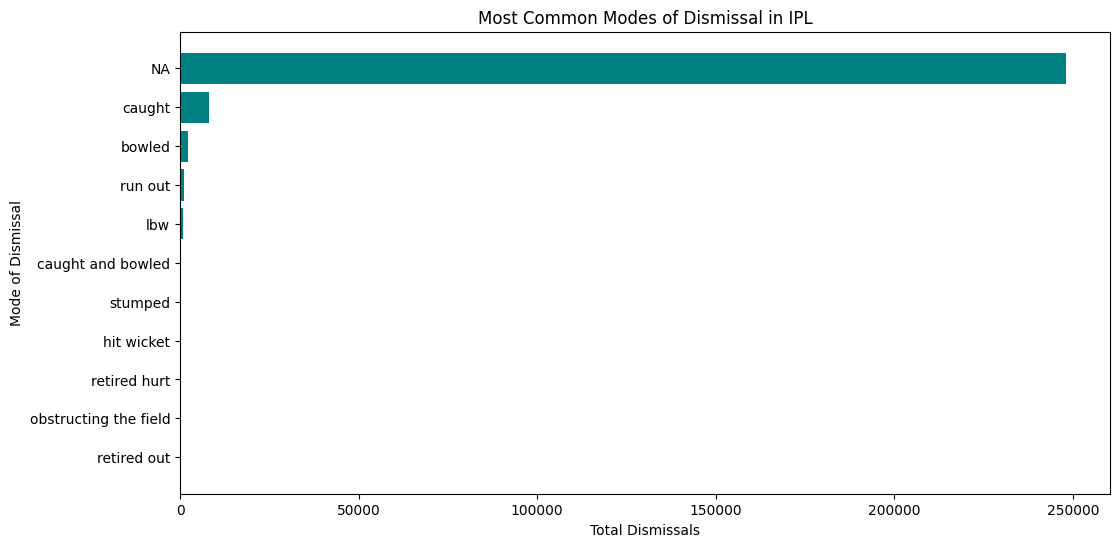

In [79]:
import matplotlib.pyplot as plt


# Convert PySpark DataFrame to Pandas for plotting
dismissal_modes_pd = dismissal_modes.toPandas()
# Set figure size
plt.figure(figsize=(12, 6))

# Create horizontal bar plot
plt.barh(dismissal_modes_pd["dismissal_kind"], dismissal_modes_pd["count"], color="teal")

# Labels and Title
plt.xlabel("Total Dismissals")
plt.ylabel("Mode of Dismissal")
plt.title("Most Common Modes of Dismissal in IPL")

# Invert y-axis for better readability
plt.gca().invert_yaxis()

# Show plot
plt.show()


# 🎯 **Conclusion: IPL Data Analysis Insights** 🏏  

## 📌 **Key Takeaways from the Analysis**  

1. **Total Matches Played Per Season 📊**  
   - The IPL has witnessed a steady increase in the number of matches, indicating its growing popularity.  

2. **Most Successful Teams 🏆**  
   - Teams like **Mumbai Indians (MI)** and **Chennai Super Kings (CSK)** have consistently dominated the tournament in terms of victories.  

3. **Toss Decisions & Impact 🏏**  
   - The majority of teams prefer to **bowl first** after winning the toss, indicating a strategic inclination towards chasing.  

4. **Highest Run Chases 🔥**  
   - Some teams have successfully chased mammoth totals, proving the effectiveness of aggressive batting strategies.  

5. **Biggest Wins by Runs 📈**  
   - The largest victories in IPL history showcase the dominance of certain teams in specific matches.  

6. **Most Player of the Match Awards 🌟**  
   - Players like **Virat Kohli, AB de Villiers, and MS Dhoni** have consistently delivered match-winning performances.  

7. **Batsmen & Bowlers' Performances ⚡**  
   - The top batsmen with the highest strike rates and six-hitting abilities have played a key role in their teams’ successes.  
   - Bowlers with the best economy rates and wicket-taking capabilities have been crucial in shaping match outcomes.  

8. **Extra Runs & Dismissals ❌**  
   - Extra runs conceded can be a game-changer, and teams need to focus on minimizing extras.  
   - **Caught behind and bowled** remain the most common modes of dismissal in the IPL.  

---

## 🎯 **Final Thoughts**  

This analysis of IPL data provides deep insights into team performances, player contributions, and match strategies. Such statistical evaluations not only help franchises make informed decisions but also enhance fan engagement by offering a data-driven perspective on the game.  

🔥 **Cricket is unpredictable, but data never lies!** 🔥  

---

